In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
import os
%matplotlib inline

from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import nltk
from nltk.corpus import stopwords

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)
Using TensorFlow backend.


In [2]:
file_list=os.listdir('../../dataset/df_train.pkl.gz/')
df_train=pd.DataFrame()
for file in file_list:
    df_train=pd.concat([df_train, 
                        pd.read_pickle('../../dataset/df_train.pkl.gz/'+file, compression='gzip')])
df_train['mission_prgrm']=df_train['mission']+'; '+df_train['prgrm_dsc']
len(df_train)

229472

In [3]:
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemma_tokenizer(str_input):
    tokens=word_tokenize(str_input)
    return ' '.join([WordNetLemmatizer().lemmatize(word=word, pos=get_wordnet_pos(pos)).upper() for word, pos in nltk.pos_tag(tokens) if word not in set(stopwords.words('english'))])

In [4]:
df_train['mission_prgrm']=df_train['mission_prgrm'].apply(lemma_tokenizer)
df_train['mission']=df_train['mission'].apply(lemma_tokenizer)
df_train['prgrm_dsc']=df_train['prgrm_dsc'].apply(lemma_tokenizer)

In [7]:
X = df_train.mission_prgrm
Y = df_train.NTEE1
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

In [8]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)

In [16]:
max_words = 10000
max_len = 500
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [30]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(len(df_train.NTEE1.unique()))
    layer = Activation('softmax')
    model = Model(inputs=inputs,outputs=layer)
    return model

In [32]:
num_labels=len(train_df['label'].drop_duplicates())
batch_size = 2000
epochs = 40

model = keras.Sequential()
model.add(keras.layers.Dense(512, input_shape=(vocab_size,)))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dense(num_labels))
model.add(keras.layers.Activation('softmax'))
model.add(keras.layers.LSTM(100))

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy']
             )

history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    verbose=1, 
                    validation_split=0.2)

NameError: name 'train_df' is not defined

In [17]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [31]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

ValueError: Output tensors to a Model must be the output of a Keras `Layer` (thus holding past layer metadata). Found: <keras.layers.core.Activation object at 0x000001D077CB0E48>

In [19]:
model.fit(sequences_matrix,Y_train,batch_size=128,epochs=20,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Train on 156040 samples, validate on 39011 samples
Epoch 1/20
156040/156040 [==============================] - 667s 4ms/step - loss: -137.7159 - acc: 0.1669 - val_loss: -138.5898 - val_acc: 0.1687
Epoch 2/20
156040/156040 [==============================] - 657s 4ms/step - loss: -138.5325 - acc: 0.1669 - val_loss: -138.5898 - val_acc: 0.1687


In [ ]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [ ]:
accr = model.evaluate(test_sequences_matrix,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

In [4]:
txt_field='mission_prgrm'
small_num=0
while small_num<100: # Make sure each category has at least 100 records.
    trainDF = df_train[df_train.mission.notna() & df_train.NTEE1.notna()].sample(100000)
    small_num=trainDF.groupby('NTEE1').count().sort_values('EIN').iloc[0]['EIN']
#### Sample ####
trainDF['text'] = trainDF[txt_field].astype(str)
trainDF['label'] = trainDF['NTEE1'].astype(str)

In [5]:
print("Total len: ", len(trainDF))
print(trainDF['label'].unique())

#test_df = pd.DataFrame(trainDF['label'].unique())
#test_df.to_csv("../../data/classification_results/results_nteecc/list_of_classes.csv")

#total classes: 1327

Total len:  100000
['N' 'W' 'B' 'P' 'S' 'E' 'I' 'L' 'A' 'Y' 'K' 'M' 'X' 'G' 'C' 'T' 'H' 'R'
 'O' 'J' 'Q' 'D' 'F' 'U' 'V']


In [31]:
import statistics

counts = trainDF['label'].value_counts().sort_index().to_frame()
counts['category'] = counts.index
counts['train_sample']=(counts['label']/2).astype(int)
    
train_df, test_df = np.split(trainDF, [int(.7*len(trainDF))])

#tf.logging.set_verbosity(tf.logging.ERROR)

train_posts = train_df['text']
train_tags = train_df['label']
test_posts = test_df['text']
test_tags = test_df['label']
vocab_size = 10000
#precision & recall by: Other text preprocessing: https://keras.io/preprocessing/text/ 
tokenize = keras.preprocessing.text.Tokenizer(num_words=vocab_size)
tokenize.fit_on_texts(train_posts)

x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)

encoder = preprocessing.LabelBinarizer()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)
    
num_labels=len(train_df['label'].drop_duplicates())
batch_size = 2000
epochs = 40

model = keras.Sequential()
model.add(keras.layers.Dense(512, input_shape=(vocab_size,)))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dense(num_labels))
model.add(keras.layers.Activation('softmax'))
model.add(keras.layers.LSTM(100))

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy']
             )

history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    verbose=1, 
                    validation_split=0.2)

ValueError: Input 0 of layer lstm_1 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: [None, 25]

In [22]:
score = model.evaluate(x_test, y_test, 
                       batch_size=batch_size, verbose=1)

30000/30000 [==============================] - 3s 116us/step


In [23]:
print(score)

[2.128798747062683, 0.6859999974568685, 0.7078190843264262, 0.6734666744867961]


In [24]:
results = model.evaluate(x_test, y_test)
print(results)

30000/30000 [==============================] - 4s 138us/step
[2.128798867638906, 0.686, 0.7077912830034891, 0.6734666666666667]


In [25]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'val_precision', 'val_recall', 'loss', 'acc', 'precision', 'recall'])

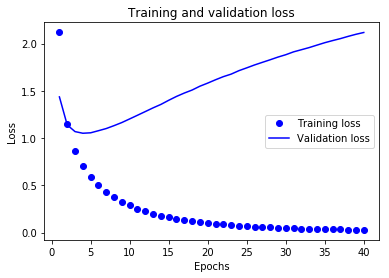

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

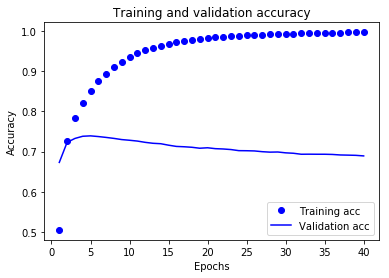

In [27]:
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [4]:
#acc till 85: increases by 2% every epoch
#acc 85 - 95: increases by 1% each epoch
# 95 - 96: 4 epochs
# 96 - 97: >18 epochs

from tqdm import tqdm_notebook as tqdm
    
all_pred = pd.DataFrame(columns=['EIN', 'text', 'actual_label', 'predicted_label', 'true_pred'])


for i in tqdm(range(len(x_test))):
    prediction = model.predict(np.array([x_test[i]]))    
    text_labels = encoder.classes_ 
    predicted_label = text_labels[np.argmax(prediction[0])]
    text = test_posts.iloc[i]
    ein = trainDF[trainDF['text']==test_posts.iloc[i]]['EIN'].astype(int).drop_duplicates().tolist()
    actual_label = trainDF[trainDF['text']==test_posts.iloc[i]]['label'].drop_duplicates().tolist()
    if(predicted_label == test_tags.iloc[i]):
        true_pred = 'true'
    else:
        true_pred = 'false'

    all_pred.loc[len(all_pred)] = [ein, text, actual_label, predicted_label, true_pred]


if(os.path.exists('../../data/classification_results/all_predictions_V3.pkl.gz')):
    all_pred = pd.concat([pd.read_pickle('../../data/classification_results/all_predictions_V3.pkl.gz'), all_pred]).drop_duplicates()
    
all_pred.to_pickle('../../data/classification_results/all_predictions_V3.pkl.gz')
